In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-05-21 20:12:45.817692: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-21 20:12:45.840307: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ffb516ab830 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-21 20:12:45.840323: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


False

In [3]:
TrianImage="/Users/yaoyutong/Desktop/Data/train/"
TestImage="/Users/yaoyutong/Desktop/Data/test/"
Normalimages = os.listdir(TrianImage + "/NORMAL")
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")
COVID19images = os.listdir(TrianImage + "/COVID19")

In [4]:
print(len(Normalimages), len(Pneumonaimages), len(COVID19images))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages) + len(COVID19images)
print(NUM_TRAINING_IMAGES)

1266 3418 460
5144


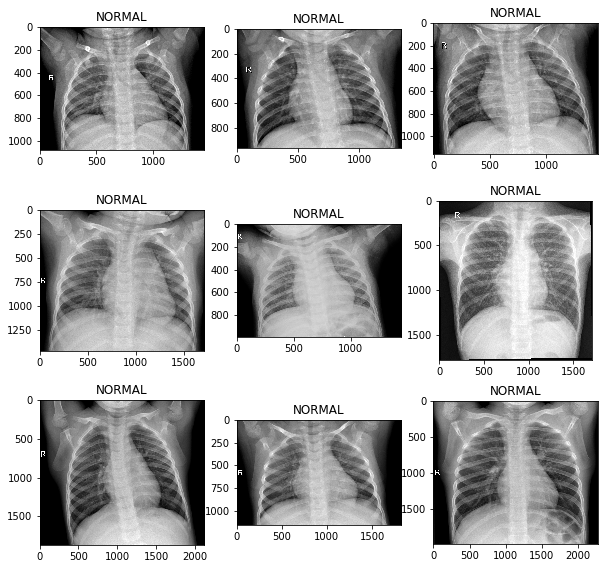

In [5]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

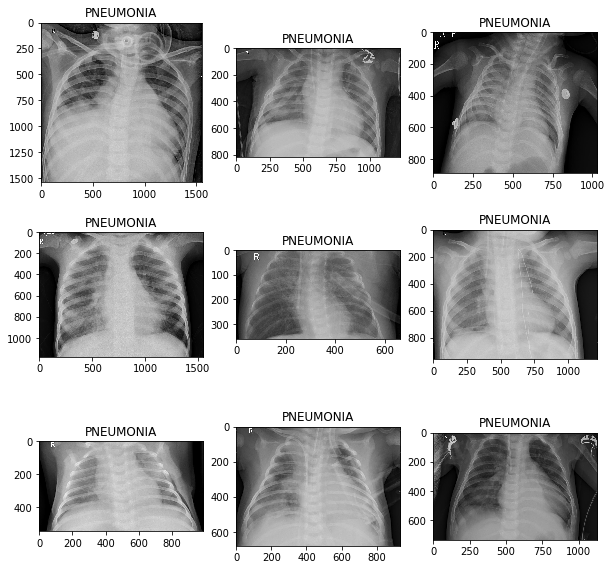

In [6]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

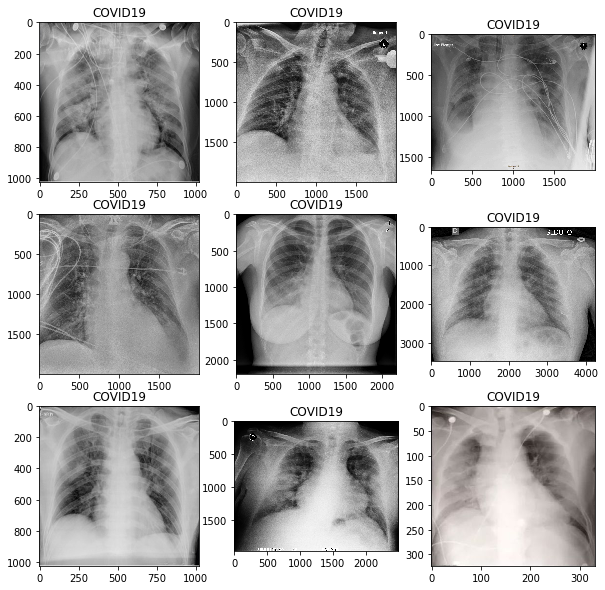

In [7]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")
plt.show()

In [8]:
image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE

data_path = '/Users/yaoyutong/Desktop/Data'

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(data_path + '/train',
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [10]:
train_x,train_y=training_set.next()

In [14]:
testing_set

In [15]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [16]:
BATCH_SIZE = 1288

In [17]:
testing_set = test_datagen.flow_from_directory(data_path + '/test',
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 1288 images belonging to 3 classes.


In [18]:
y_test = testing_set.__getitem__(0)[1] 

In [19]:
y_test.shape

(1288, 3)

In [35]:
y_test

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [41]:
testing_set.class_indices

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}

In [ ]:
labels = ['COVID19', 'NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [ ]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [32]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [29]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [30]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights


{0: 7.430434782608696, 1: 2.6998420221169037, 2: 1.0}

In [31]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])

model_densenet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [51]:
plot_model(model_densenet, show_shapes=True, to_file='model_densenet.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [33]:
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set,callbacks=[lr_reduce, es_callback], epochs=5)   


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
322/322 [==============================] - 1026s 3s/step - loss: 0.5822 - accuracy: 0.8589 - val_loss: 0.4264 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 2/5
322/322 [==============================] - 912s 3s/step - loss: 0.4919 - accuracy: 0.9185 - val_loss: 0.4113 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 3/5
322/322 [==============================] - 896s 3s/step - loss: 0.4733 - accuracy: 0.9244 - val_loss: 0.4540 - val_accuracy: 0.9208 - lr: 1.0000e-04
Epoch 4/5
322/322 [==============================] - 926s 3s/step - loss: 0.4559 - accuracy: 0.9357 - val_loss: 0.3984 - val_accuracy: 0.9457 - lr: 1.0000e-04
Epoch 5/5
322/322 [==============================] - 884s 3s/step - loss: 0.4483 - accuracy: 0.9432 - val_loss: 0.4060 - val_accuracy: 0.9449 - lr: 1.0000e-04


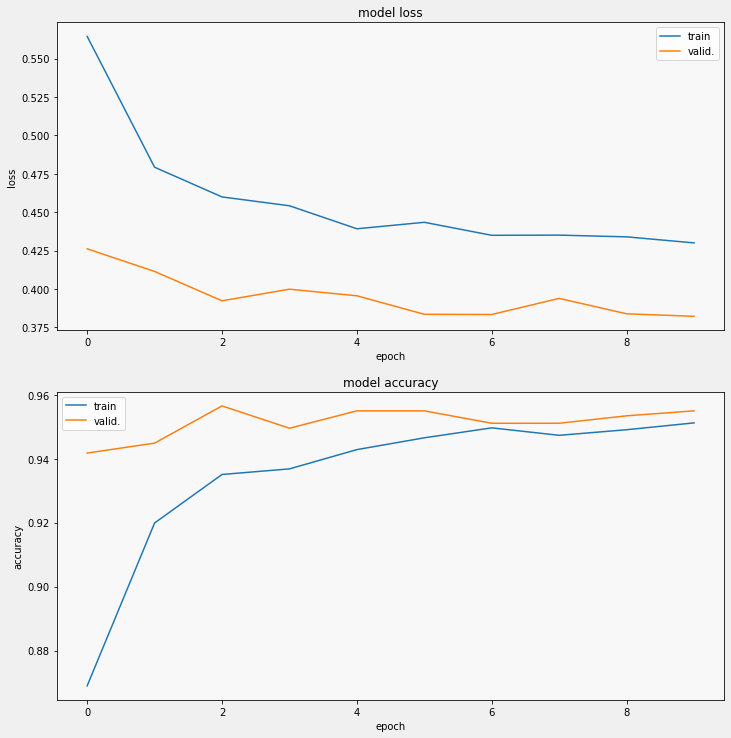

In [54]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)


In [55]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

In [57]:
data_path

'/Users/yaoyutong/Desktop/Data'

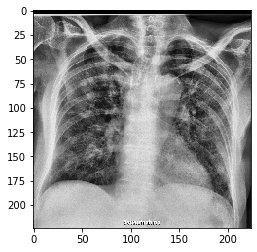

In [59]:
# test image
file_path = '/test/COVID19/COVID19(164).jpg'
test_image = cv2.imread(data_path + file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [60]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as COVID19


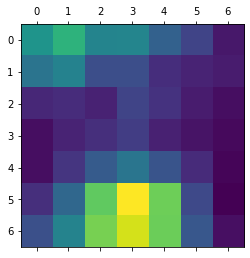

In [61]:
plt.matshow(heatmap)
plt.show()

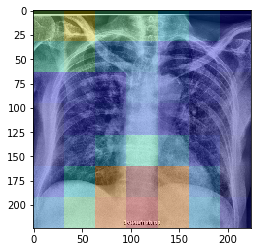

In [62]:
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

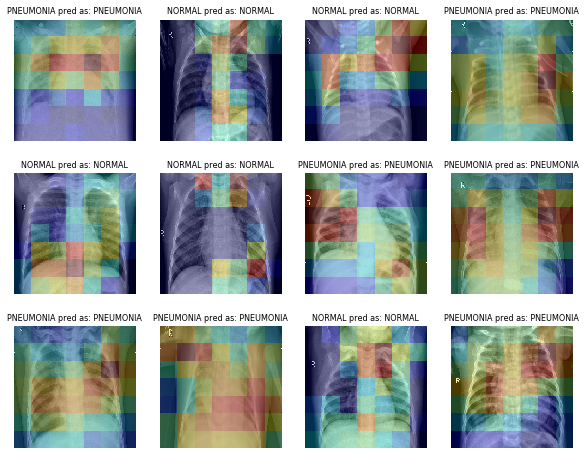

In [63]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)
    

In [64]:
model_densenet.save("model_densenet_30_09596.h5")

In [ ]:
#第二个模型

In [65]:
# https://github.com/keras-team/keras/issues/9064
pretrained_efnet = efn.EfficientNetB7(input_shape=(image_size, image_size, 3), weights='noisy-student', include_top=False)

for layer in pretrained_efnet.layers:
  layer.trainable = False

x2 = pretrained_efnet.output
x2 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_head")(x2)
x2 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x2)
x2 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x2)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x2)

model_efnet = Model(inputs=pretrained_efnet.input, outputs=model_out)
model_efnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
model_efnet.summary()

258072576/258068648 [==============================] - 869s 3us/step
Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_18[0][0]                   
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
______________________

In [66]:
plot_model(model_efnet, show_shapes=True, to_file='model_efnet.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [67]:
history_efnet = model_efnet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)  

Epoch 1/10
322/322 [==============================] - 1226s 4s/step - loss: 0.6737 - accuracy: 0.7757 - val_loss: 0.5143 - val_accuracy: 0.8874 - lr: 1.0000e-04
Epoch 2/10
322/322 [==============================] - 1272s 4s/step - loss: 0.5782 - accuracy: 0.8501 - val_loss: 0.4922 - val_accuracy: 0.9130 - lr: 1.0000e-04
Epoch 3/10
322/322 [==============================] - 1301s 4s/step - loss: 0.5508 - accuracy: 0.8725 - val_loss: 0.4584 - val_accuracy: 0.9379 - lr: 1.0000e-04
Epoch 4/10
322/322 [==============================] - 1266s 4s/step - loss: 0.5345 - accuracy: 0.8791 - val_loss: 0.5089 - val_accuracy: 0.8665 - lr: 1.0000e-04
Epoch 5/10
322/322 [==============================] - 1263s 4s/step - loss: 0.5322 - accuracy: 0.8841 - val_loss: 0.4679 - val_accuracy: 0.9325 - lr: 1.0000e-04
Epoch 6/10
322/322 [==============================] - ETA: 0s - loss: 0.5212 - accuracy: 0.8970
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
322/322 [==========

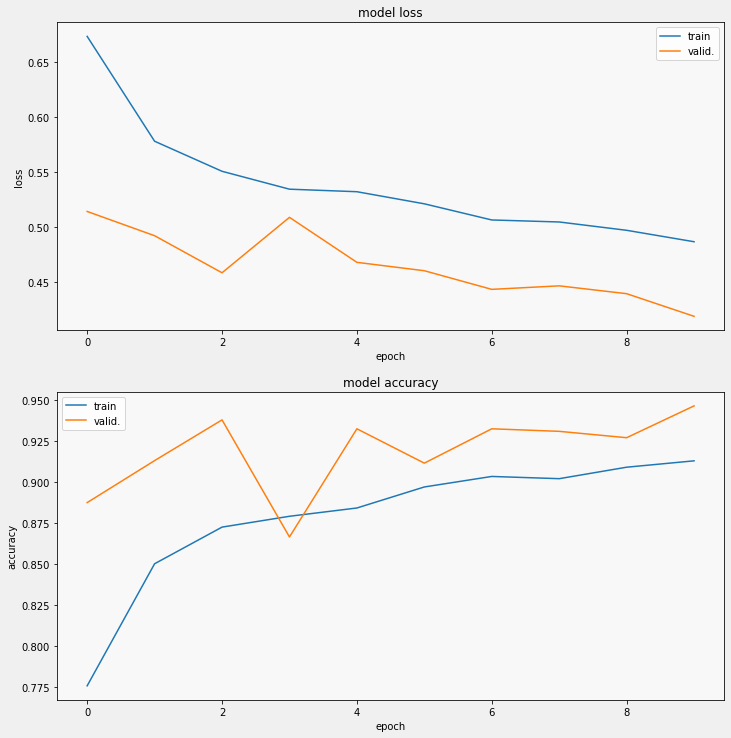

In [68]:
display_training_curves(history_efnet.history['loss'], history_efnet.history['val_loss'], 'loss', 211)
display_training_curves(history_efnet.history['accuracy'], history_efnet.history['val_accuracy'], 'accuracy', 212)

In [ ]:
last_conv_layer_name = "top_conv"
classifier_layer_names = [
    "top_bn",
    "top_activation",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

In [ ]:
# sample_data = testing_set.__getitem__(0)[0] 
# sample_label = testing_set.__getitem__(0)[1] 

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_efnet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [69]:
model_efnet.save("model_efnet_30_09169.h5")

In [ ]:
#第三个模型

In [70]:
pretrained_vgg = tf.keras.applications.VGG16(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_vgg.layers:
  layer.trainable = False

x3 = pretrained_vgg.output
x3 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x3)
x3 = tf.keras.layers.Flatten(name="flatten_head")(x3)
x3 = tf.keras.layers.Dense(128, activation="relu", name="dense_head")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x3)
x3 = tf.keras.layers.Dense(64, activation="relu", name="dense_head_2")(x3)
x3 = tf.keras.layers.Dropout(0.5, name="dropout_head_2")(x3)
model_out = tf.keras.layers.Dense(3, activation='softmax', name="predictions_head")(x3)

model_vgg = Model(inputs=pretrained_vgg.input, outputs=model_out)
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
# model_vgg.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=['accuracy'])
model_vgg.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [71]:
plot_model(model_vgg, show_shapes=True, to_file='model_efnet.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [72]:
history_vgg = model_vgg.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)  

Epoch 1/10
322/322 [==============================] - 1112s 3s/step - loss: 0.7931 - accuracy: 0.7117 - val_loss: 0.5783 - val_accuracy: 0.8315 - lr: 1.0000e-04
Epoch 2/10
322/322 [==============================] - 1092s 3s/step - loss: 0.6254 - accuracy: 0.8099 - val_loss: 0.4993 - val_accuracy: 0.8781 - lr: 1.0000e-04
Epoch 3/10
322/322 [==============================] - 1056s 3s/step - loss: 0.5693 - accuracy: 0.8606 - val_loss: 0.4713 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 4/10
322/322 [==============================] - 1063s 3s/step - loss: 0.5337 - accuracy: 0.8869 - val_loss: 0.4471 - val_accuracy: 0.9169 - lr: 1.0000e-04
Epoch 5/10
322/322 [==============================] - 1133s 4s/step - loss: 0.5113 - accuracy: 0.8999 - val_loss: 0.4530 - val_accuracy: 0.9123 - lr: 1.0000e-04
Epoch 6/10
322/322 [==============================] - 1057s 3s/step - loss: 0.5034 - accuracy: 0.9129 - val_loss: 0.4401 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 7/10
322/322 [==============

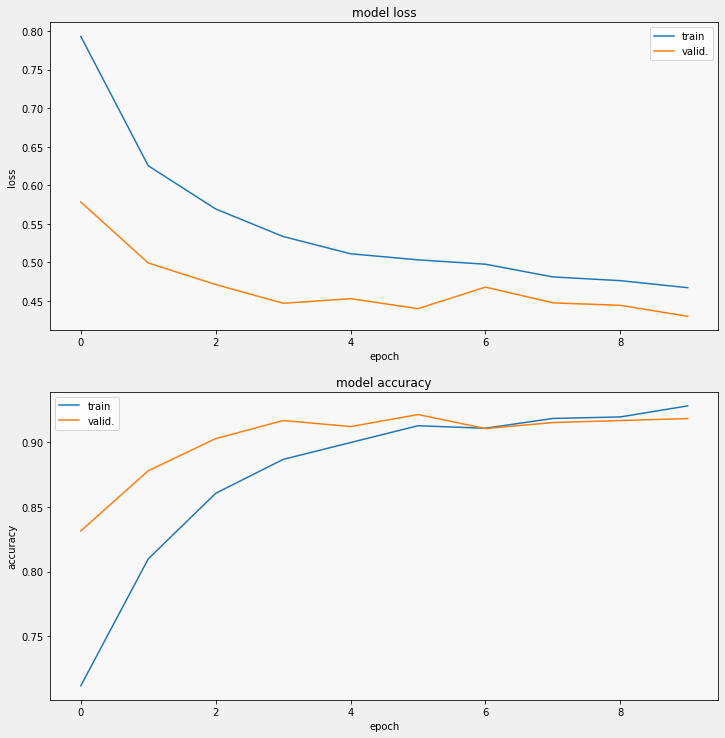

In [73]:
display_training_curves(history_vgg.history['loss'], history_vgg.history['val_loss'], 'loss', 211)
display_training_curves(history_vgg.history['accuracy'], history_vgg.history['val_accuracy'], 'accuracy', 212)

In [74]:
last_conv_layer_name = "block5_pool"
classifier_layer_names = [
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "dense_head_2",
    "dropout_head_2",
    "predictions_head"
]

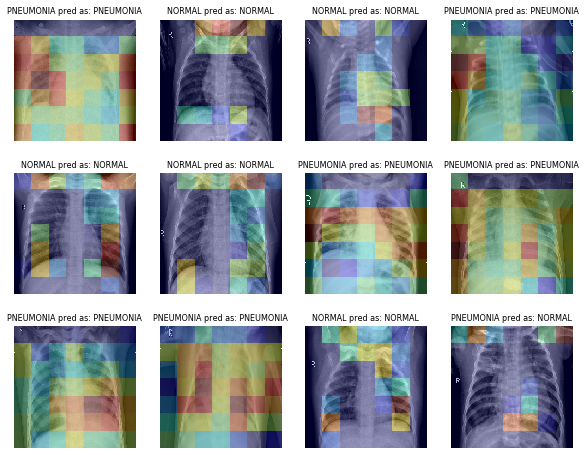

In [75]:
plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_vgg, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

In [76]:
model_vgg.save("model_vgg_30_09286.h5")

In [171]:
from sklearn.metrics import confusion_matrix#混淆矩阵
import numpy as np

def sen(Y_test,Y_pred,n):#n为分类数
    
    sen = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        tp = con_mat[i][i]
        fn = np.sum(con_mat[i,:]) - tp
        sen1 = tp / (tp + fn)
        sen.append(sen1)
        
    return sen

def pre(Y_test,Y_pred,n):
    
    pre = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        tp = con_mat[i][i]
        fp = np.sum(con_mat[:,i]) - tp
        pre1 = tp / (tp + fp)
        pre.append(pre1)
        
    return pre

def spe(Y_test,Y_pred,n):
    
    spe = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        number = np.sum(con_mat[:,:])
        tp = con_mat[i][i]
        fn = np.sum(con_mat[i,:]) - tp
        fp = np.sum(con_mat[:,i]) - tp
        tn = number - tp - fn - fp
        spe1 = tn / (tn + fp)
        spe.append(spe1)
    
    return spe

def ACC(Y_test,Y_pred,n):
    
    acc = []
    con_mat = confusion_matrix(Y_test,Y_pred)
    for i in range(n):
        number = np.sum(con_mat[:,:])
        tp = con_mat[i][i]
        fn = np.sum(con_mat[i,:]) - tp
        fp = np.sum(con_mat[:,i]) - tp
        tn = number - tp - fn - fp
        acc1 = (tp + tn) / number
        acc.append(acc1)
        
    return acc



In [154]:
y_test_auc=to_categorical(y_test, 3)

In [137]:
y_vgg=np.argmax(model_vgg.predict(x_test),axis=1)

In [143]:
y_vgg_pred=model_vgg.predict(x_test)

In [150]:
from keras.utils import to_categorical
y_vgg_auc=to_categorical(y_vgg, 3)

In [140]:
from sklearn.metrics import confusion_matrix,classification_report
#predictions = np.argmax(model.predict(X),axis=1)
print(confusion_matrix(y_test, y_vgg))
print(classification_report(y_test, y_vgg))

[[101  11   4]
 [  0 296  21]
 [  2  67 786]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       116
           1       0.79      0.93      0.86       317
           2       0.97      0.92      0.94       855

    accuracy                           0.92      1288
   macro avg       0.91      0.91      0.91      1288
weighted avg       0.93      0.92      0.92      1288



In [155]:
from sklearn.metrics import plot_roc_curve,roc_curve,auc,roc_auc_score
# Compute ROC curve and ROC area for each class
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # 取出来的是各个类的测试值和预测值
    fpr[i], tpr[i],_ = roc_curve(y_test_auc[:, i],y_vgg_auc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#Compute micro-average ROC curve and ROC area
#类总和的基础上平均的ROC 和 AUC
fpr["micro"],tpr["micro"],_ = roc_curve(y_test_auc.ravel(), y_vgg_auc.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

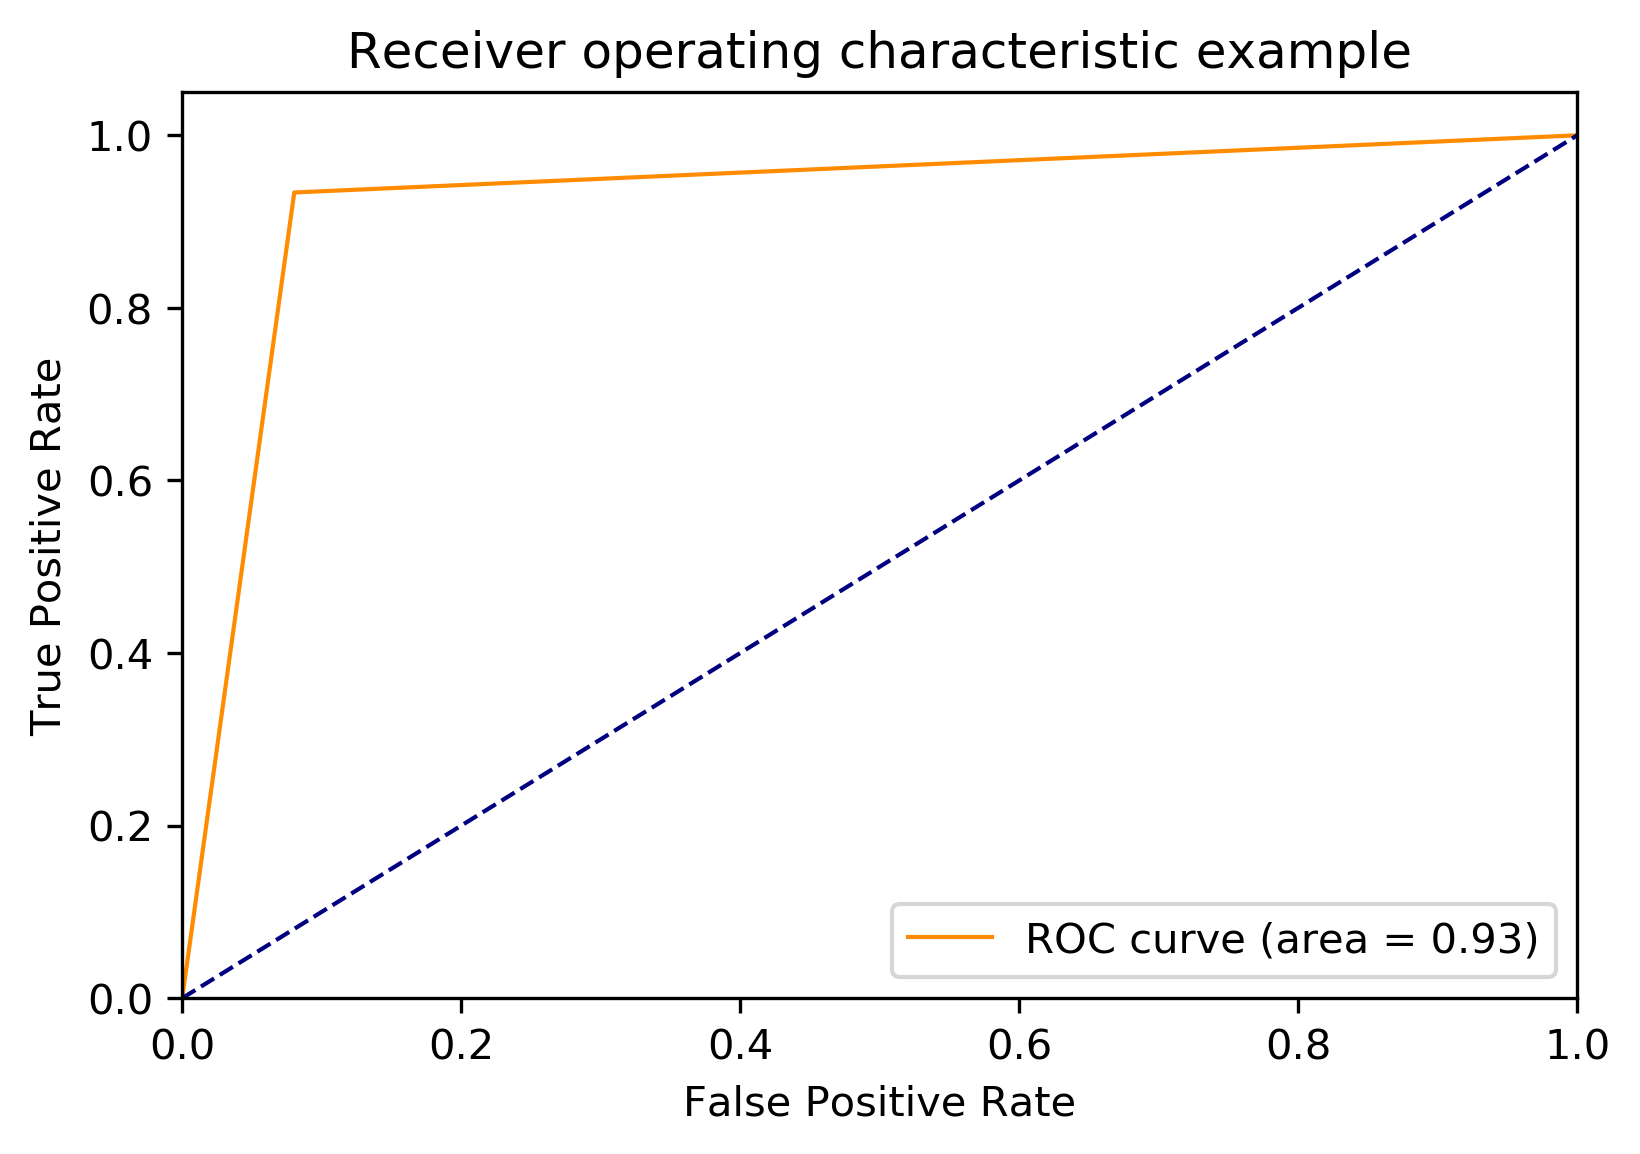

In [156]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.figure()
# linewidth
lw = 1
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [176]:
acc_vgg=ACC(y_test,y_vgg,3)
acc_vgg = sum(acc_vgg) / len(acc_vgg)
acc_vgg

0.9456521739130435

In [180]:
sen_vgg=sen(y_test,y_vgg,3)
sen_vgg = sum(sen_vgg) / len(sen_vgg)
sen_vgg

0.9079139480013714

In [182]:
spe_vgg=spe(y_test,y_vgg,3)
spe_vgg = sum(spe_vgg) / len(spe_vgg)
spe_vgg

0.9534090792155067

In [184]:
pre_vgg=pre(y_test,y_vgg,3)
pre_vgg = sum(pre_vgg) / len(pre_vgg)
pre_vgg

0.9137334113240078

In [138]:
y_efnet=np.argmax(model_efnet.predict(x_test),axis=1)

In [144]:
y_efnet_pred=model_efnet.predict(x_test)

In [152]:
from keras.utils import to_categorical
y_efnet_auc=to_categorical(y_efnet, 3)

In [141]:
print(confusion_matrix(y_test, y_efnet))
print(classification_report(y_test, y_efnet))

[[111   4   1]
 [  2 298  17]
 [  0  45 810]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       116
           1       0.86      0.94      0.90       317
           2       0.98      0.95      0.96       855

    accuracy                           0.95      1288
   macro avg       0.94      0.95      0.94      1288
weighted avg       0.95      0.95      0.95      1288



In [157]:
from sklearn.metrics import plot_roc_curve,roc_curve,auc,roc_auc_score
# Compute ROC curve and ROC area for each class
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # 取出来的是各个类的测试值和预测值
    fpr[i], tpr[i],_ = roc_curve(y_test_auc[:, i],y_efnet_auc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#Compute micro-average ROC curve and ROC area
#类总和的基础上平均的ROC 和 AUC
fpr["micro"],tpr["micro"],_ = roc_curve(y_test_auc.ravel(), y_efnet_auc.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

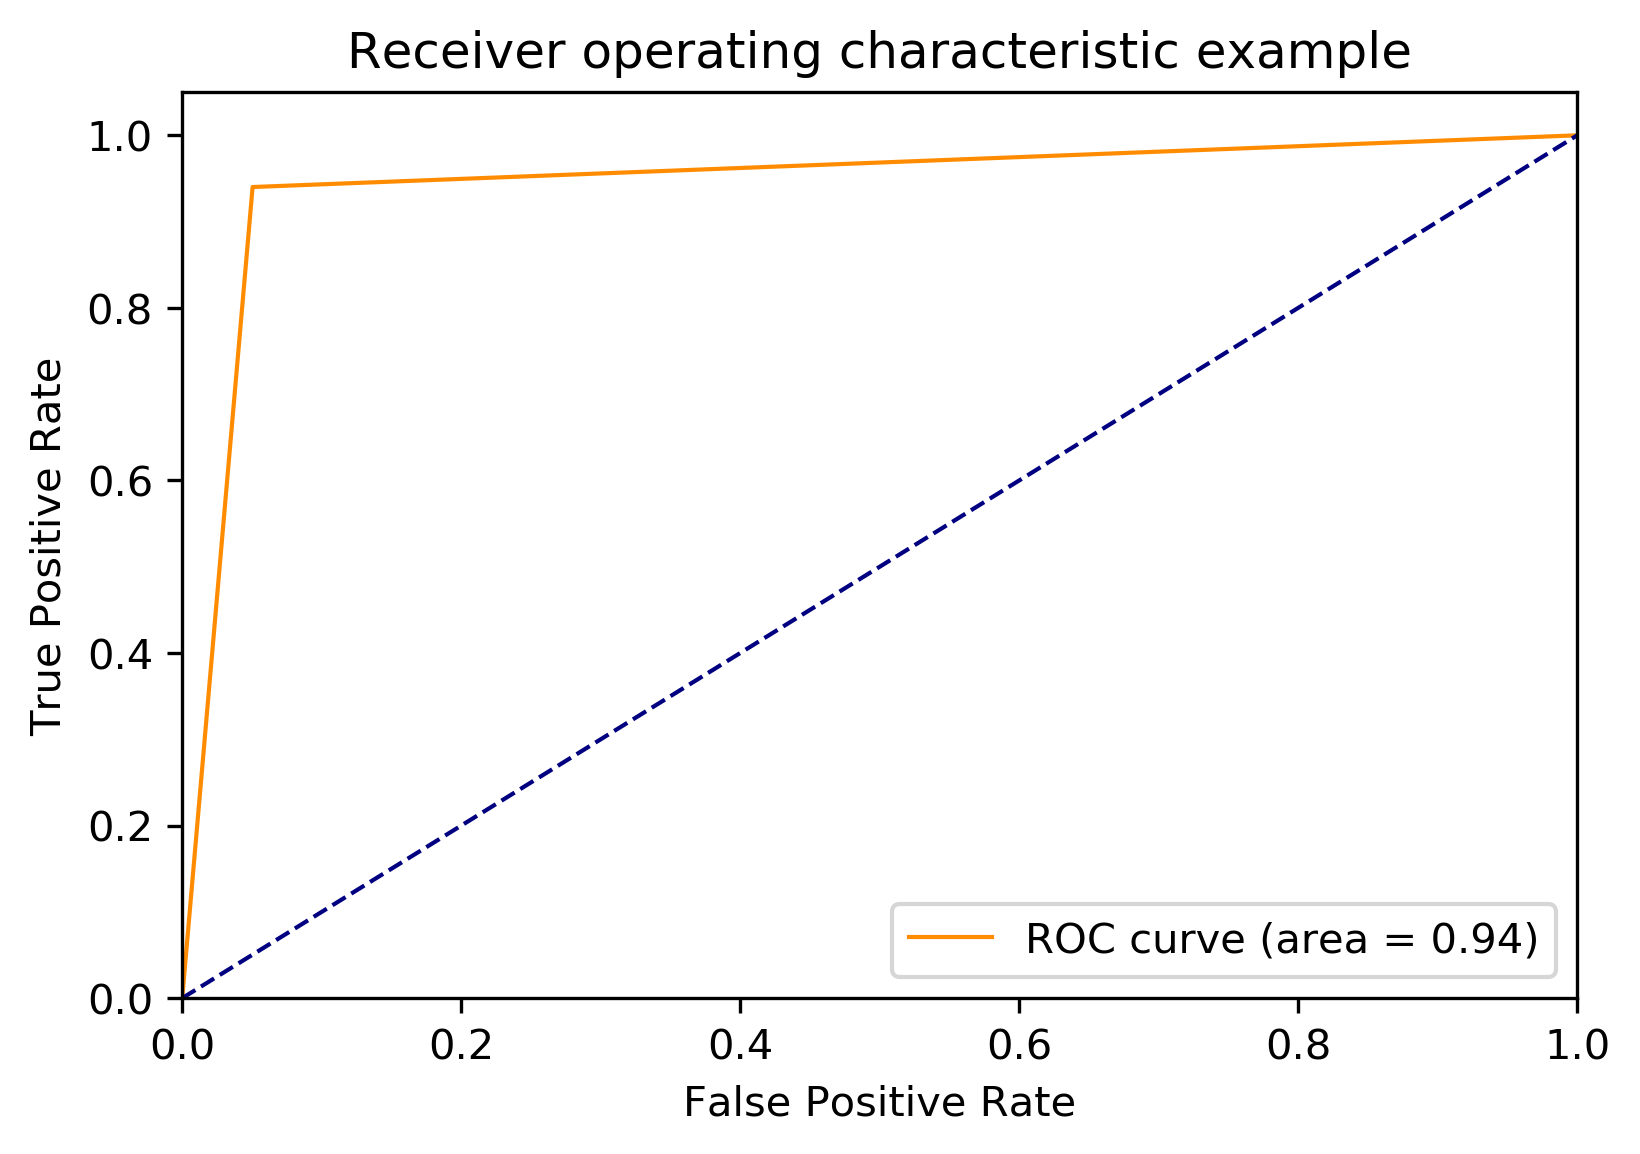

In [158]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.figure()
# linewidth
lw = 1
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [185]:
acc_efnet=ACC(y_test,y_efnet,3)
acc_efnet = sum(acc_efnet) / len(acc_efnet)
acc_efnet

0.9642857142857143

In [186]:
sen_efnet=sen(y_test,y_efnet,3)
sen_efnet = sum(sen_efnet) / len(sen_efnet)
sen_efnet

0.9481093547531397

In [187]:
spe_efnet=spe(y_test,y_efnet,3)
spe_efnet = sum(spe_efnet) / len(spe_efnet)
spe_efnet

0.9687532122688177

In [188]:
pre_efnet=pre(y_test,y_efnet,3)
pre_efnet = sum(pre_efnet) / len(pre_efnet)
pre_efnet

0.9397837932937333

In [139]:
y_densenet=np.argmax(model_densenet.predict(x_test),axis=1)

In [145]:
y_densenet_pred=model_densenet.predict(x_test)

In [153]:
from keras.utils import to_categorical
y_densenet_auc=to_categorical(y_densenet, 3)

In [142]:
print(confusion_matrix(y_test, y_densenet))
print(classification_report(y_test, y_densenet))

[[111   2   3]
 [  0 297  20]
 [  0  33 822]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       116
           1       0.89      0.94      0.92       317
           2       0.97      0.96      0.97       855

    accuracy                           0.95      1288
   macro avg       0.96      0.95      0.95      1288
weighted avg       0.96      0.95      0.96      1288



In [159]:
from sklearn.metrics import plot_roc_curve,roc_curve,auc,roc_auc_score
# Compute ROC curve and ROC area for each class
n_classes=3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # 取出来的是各个类的测试值和预测值
    fpr[i], tpr[i],_ = roc_curve(y_test_auc[:, i],y_densenet_auc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
#Compute micro-average ROC curve and ROC area
#类总和的基础上平均的ROC 和 AUC
fpr["micro"],tpr["micro"],_ = roc_curve(y_test_auc.ravel(), y_densenet_auc.ravel())
roc_auc["micro"] = auc(fpr["micro"],tpr["micro"])

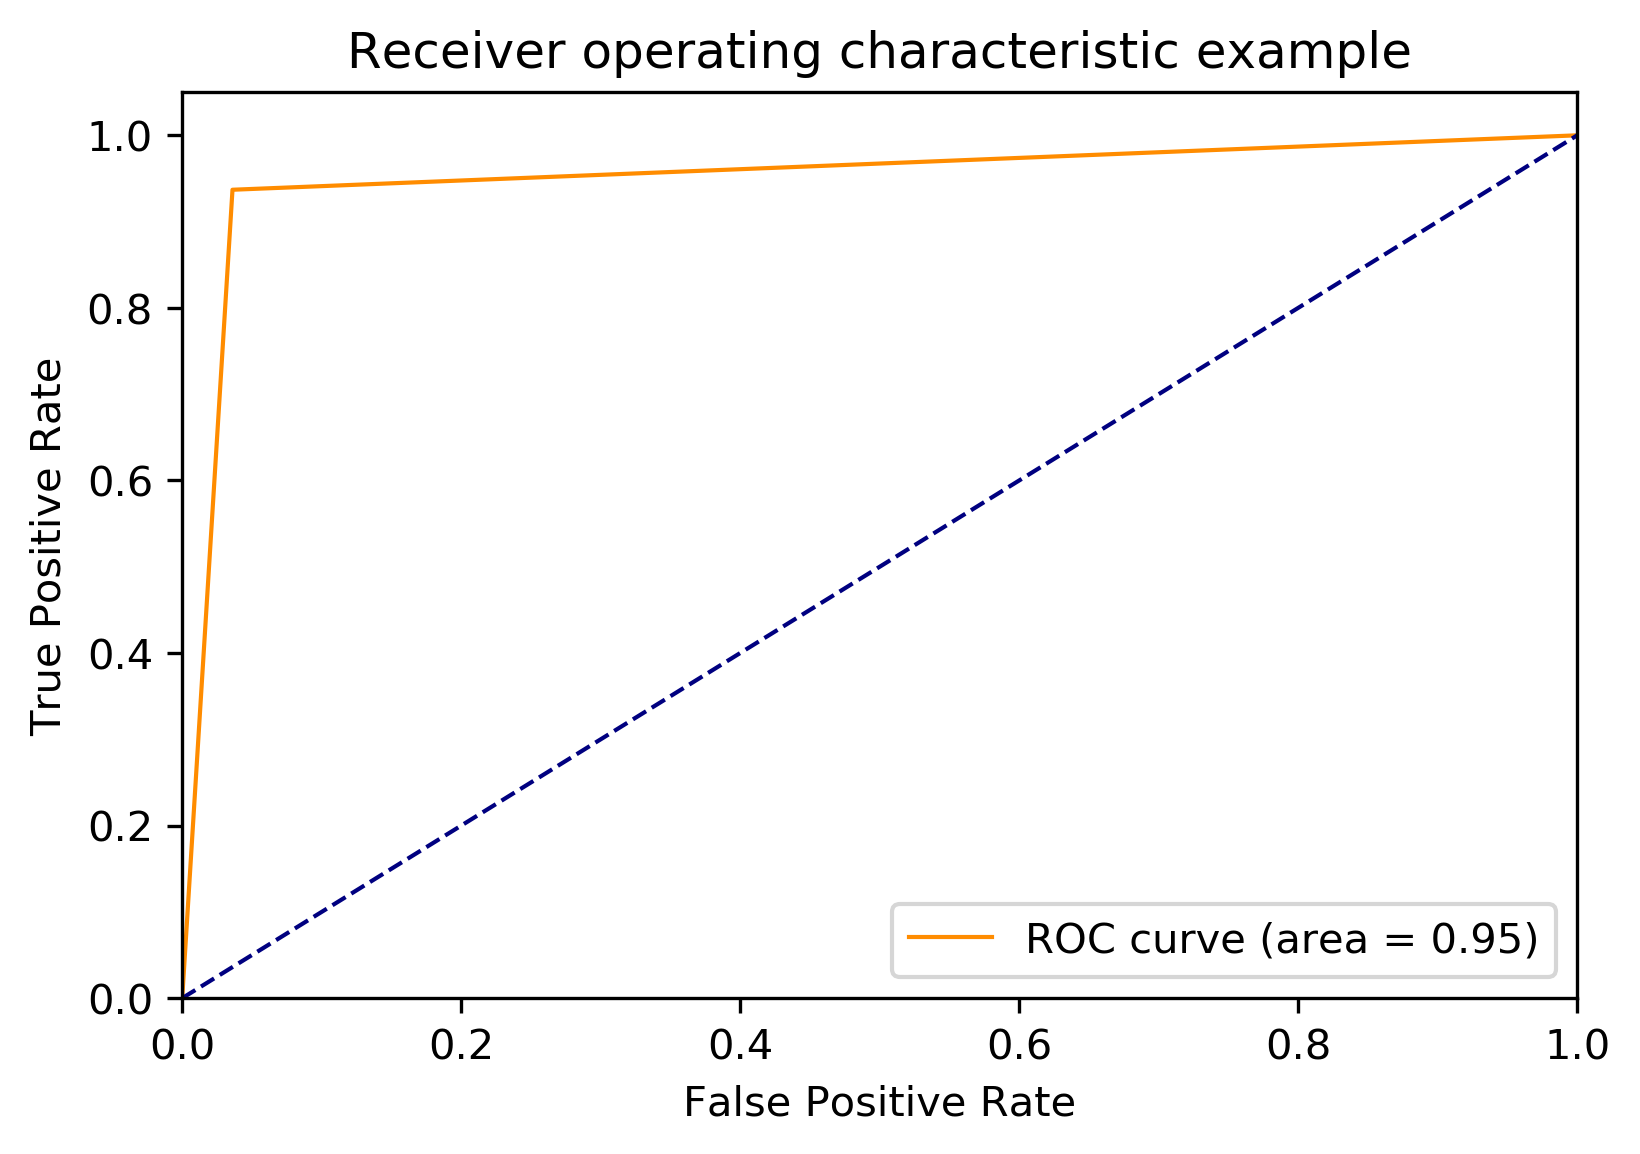

In [160]:
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.figure()
# linewidth
lw = 1
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [189]:
acc_densenet=ACC(y_test,y_densenet,3)
acc_densenet = sum(acc_densenet) / len(acc_densenet)
acc_densenet

0.9699792960662524

In [190]:
sen_densenet=sen(y_test,y_densenet,3)
sen_densenet = sum(sen_densenet) / len(sen_densenet)
sen_densenet

0.9517361926154084

In [191]:
spe_densenet=spe(y_test,y_efnet,3)
spe_densenet = sum(spe_densenet) / len(spe_densenet)
spe_densenet

0.9687532122688177

In [192]:
pre_densenet=pre(y_test,y_densenet,3)
pre_densenet = sum(pre_densenet) / len(pre_densenet)
pre_densenet

0.9557864594472565

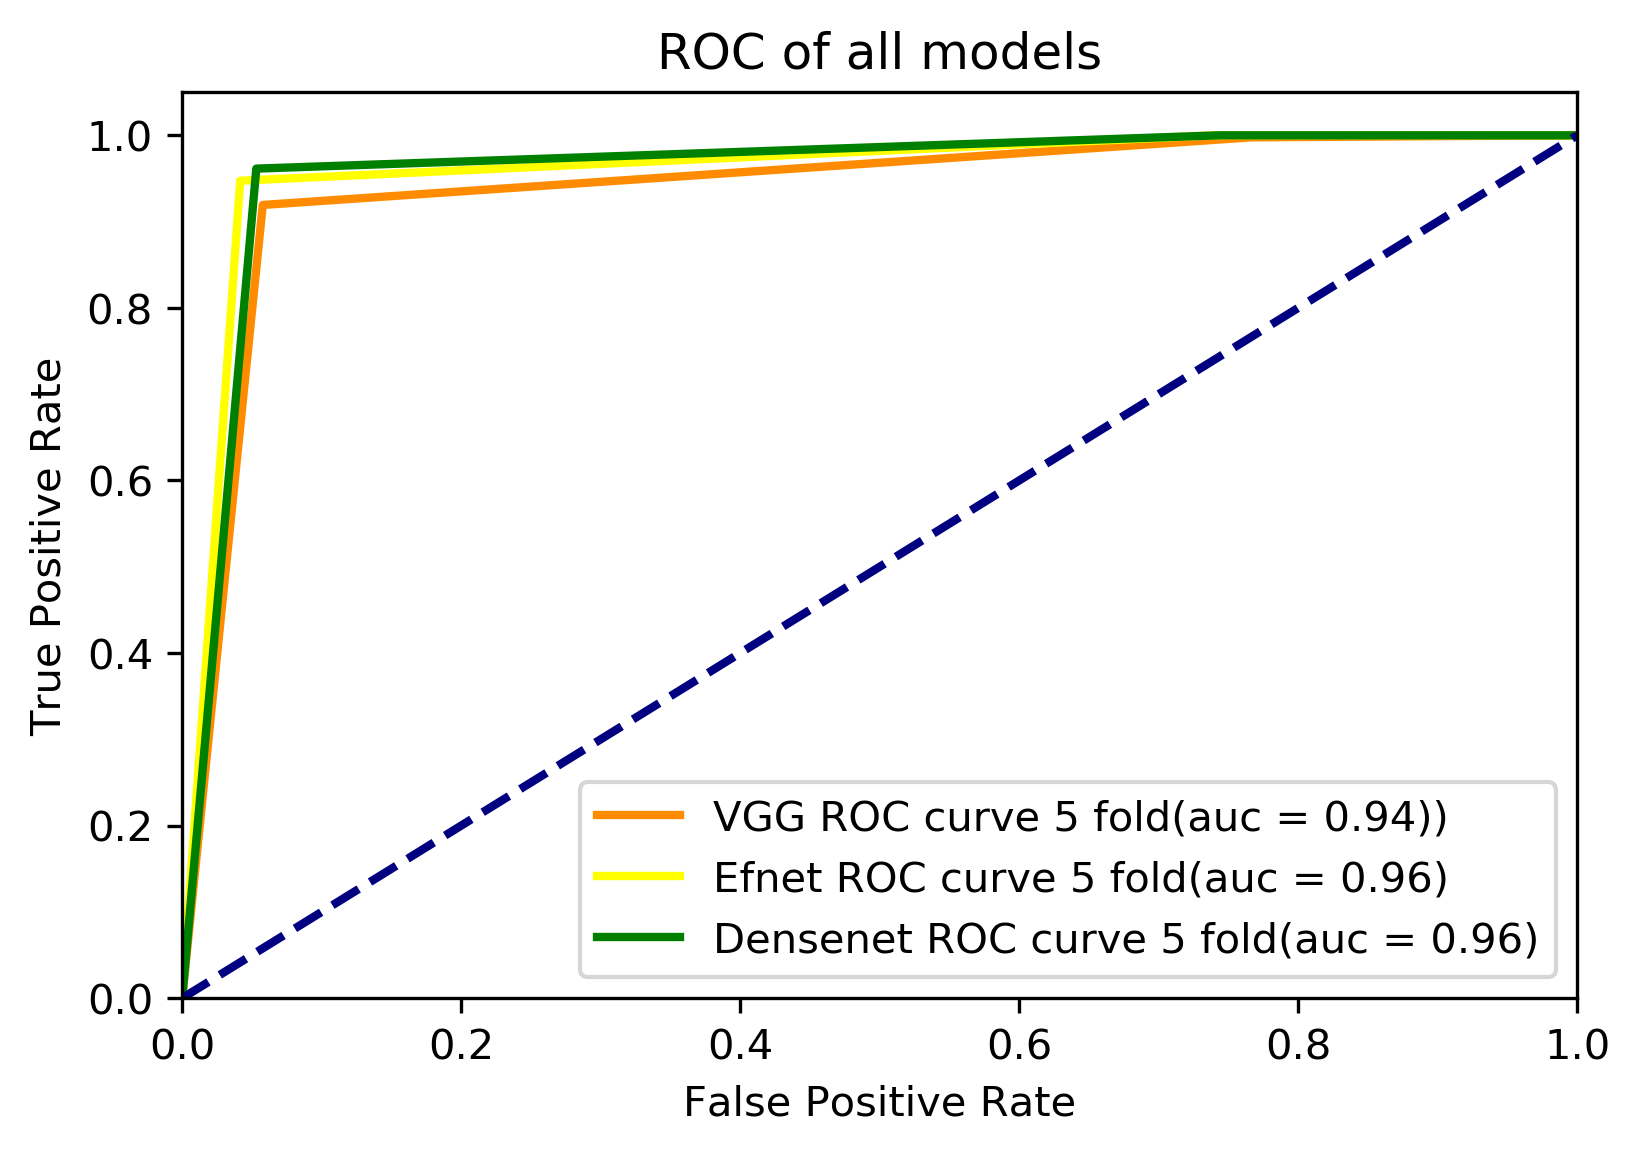

In [193]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr1, tpr1, _ = roc_curve(y_test, y_vgg,pos_label=2)
fpr2, tpr2, _ = roc_curve(y_test, y_efnet,pos_label=2)
fpr3, tpr3, _ = roc_curve(y_test, y_densenet,pos_label=2)
#fpr4, tpr4, _ = roc_curve(y_test, y_pred45,pos_label=2)


roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
#roc_auc4 = auc(fpr4, tpr4)
#roc_auc5 = auc(fpr5, tpr5)
plt.figure()
lw = 2
plt.plot(fpr1, tpr1, color='darkorange',
        lw=lw, label='VGG ROC curve 5 fold(auc = %0.2f))' % roc_auc1)
plt.plot(fpr2, tpr2, color='yellow',
         lw=lw, label='Efnet ROC curve 5 fold(auc = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, color='green',
         lw=lw, label='Densenet ROC curve 5 fold(auc = %0.2f)' % roc_auc3)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of all models')
plt.legend(loc="lower right")
plt.savefig('ROC_inception.svg')
plt.show()
# plt.save('ROC_final.svg')

In [ ]:
#Densenet每一类的auroc

/Users/yaoyutong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


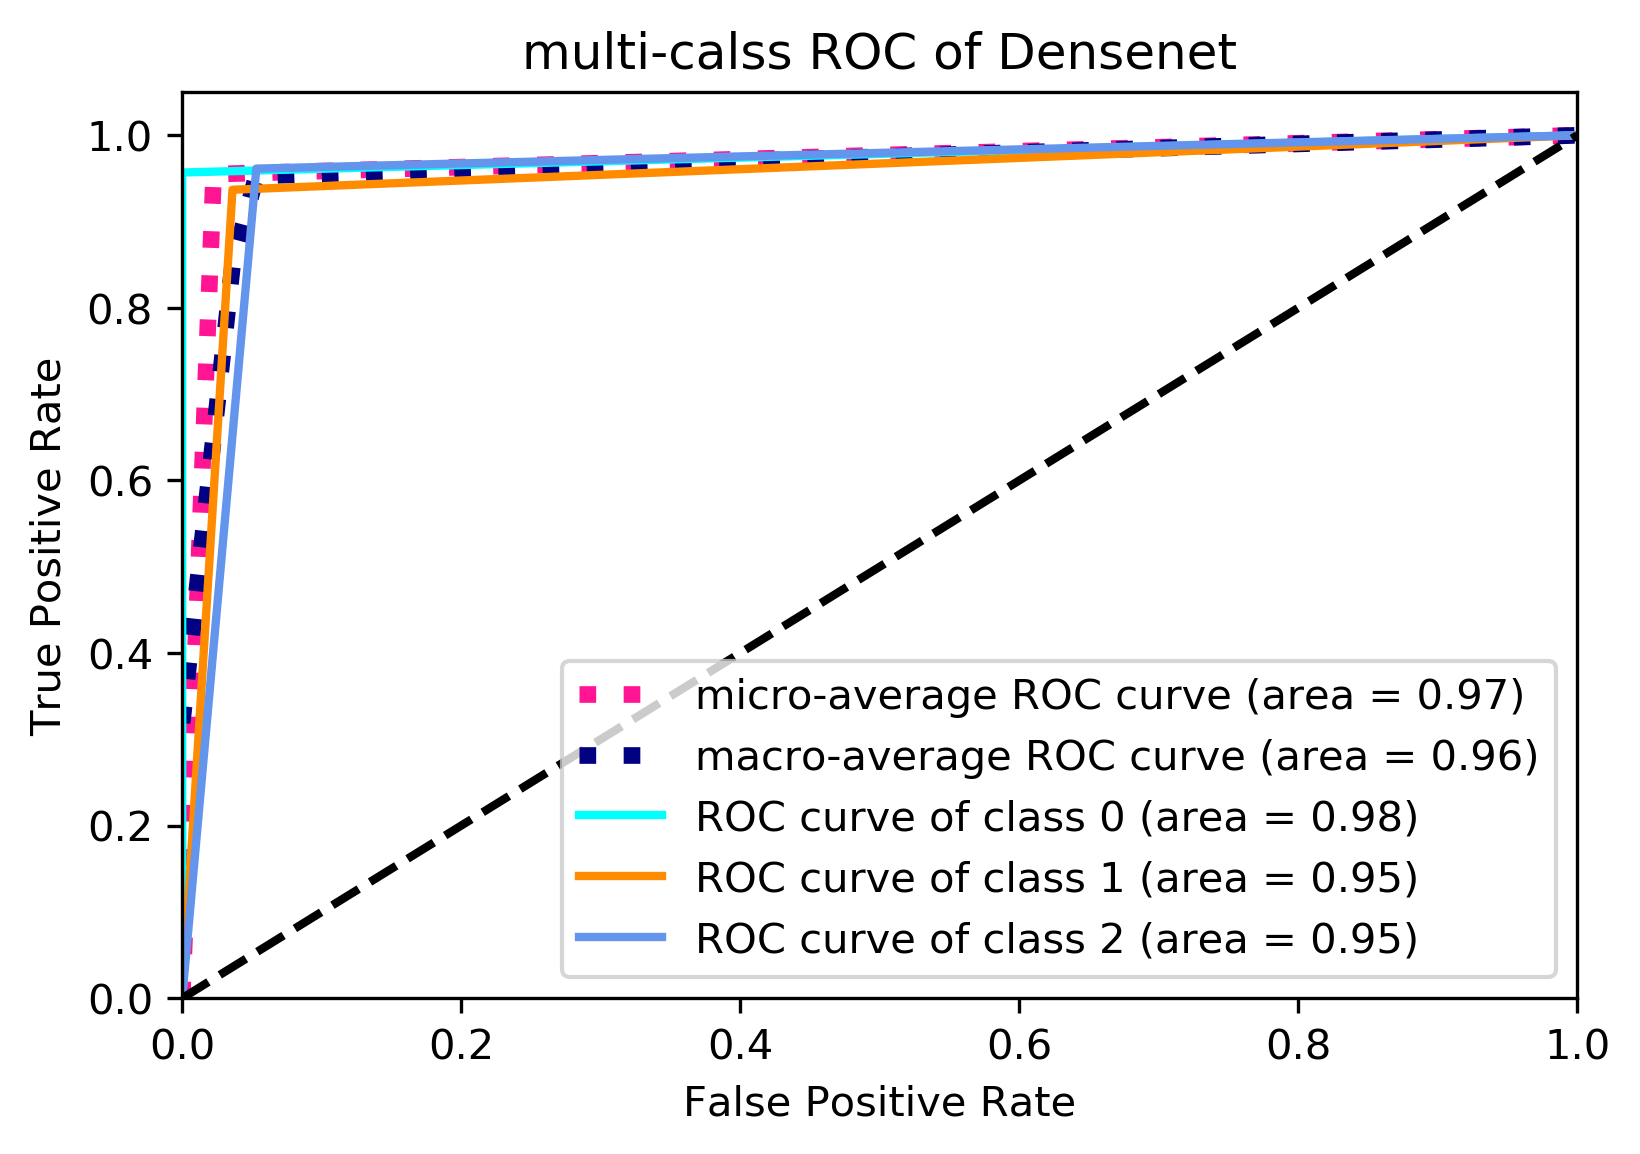

In [194]:
from scipy import interp
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

n_classes=3
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_auc[:, i],y_densenet_auc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
 
# Compute micro-average ROC curve and ROC area（方法二）
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_auc.ravel(), y_densenet_auc.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
 
# Compute macro-average ROC curve and ROC area（方法一）
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
 
# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
 
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
 
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
 
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('multi-calss ROC of Densenet')
plt.legend(loc="lower right")
plt.show()

